<a href="https://colab.research.google.com/github/208B1A0428/RESUME-PROJECTS/blob/master/image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

ViTConfig {
  "_name_or_path": "nateraw/vit-base-beans",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "finetuning_task": "image-classification",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2"
}

In [ ]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [ ]:
import os

# Directory containing image files
directory = "/content"

# List to store image file paths
image_paths = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    # Check if the file is a JPEG or JPG image
    if filename.lower().endswith('.jpeg') or filename.lower().endswith('.jpg'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Add the file path to the list
        image_paths.append(file_path)




In [ ]:
from PIL import Image
import torch

ids_list=[]
emb_list=[]
def finding_emb(image_paths, model, transformation_chain, device):
    """Fetches the `top_k` similar images with `image_path` as the query."""
    z=[]
    for ids, i in enumerate(image_paths):
      ids_list.append(ids)
    # Load the input query image.
      image = Image.open(i).convert("RGB")
    # Prepare the input query image for embedding computation.
      z.append(transformation_chain(image))

    image_batch_transformed = torch.stack(z)

    new_batch = {"pixel_values": image_batch_transformed.to(device)}

    # Compute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return query_embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
kk=finding_emb(image_paths, model, transformation_chain, device)

all_embeddings = dict(zip(ids_list, kk))


In [ ]:
import numpy as np

all_candidate_embeddings = np.array(kk)
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [ ]:
from tqdm.auto import tqdm


candidate_ids = []

for id,label in enumerate(image_paths):


    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)

In [ ]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image_path, top_k=5):
    image = Image.open(image_path).convert("RGB")

    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Compute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()


    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
    #print(similarity_mapping)

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    print(similarity_mapping_sorted)
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x:(x.split("_")[-1]), id_entries))
    return ids, labels

In [ ]:
cc,mm=fetch_similar("/content/WhatsApp Image 2024-04-11 at 12.51.06 PM (1).jpeg")

{'14_/content/WhatsApp Image 2024-04-11 at 12.51.06 PM (1).jpeg': 1.0, '0_/content/WhatsApp Image 2024-04-11 at 12.51.06 PM.jpeg': 0.4971080720424652, '3_/content/WhatsApp Image 2024-04-11 at 12.51.07 PM.jpeg': 0.4676499366760254, '1_/content/WhatsApp Image 2024-04-11 at 12.51.07 PM (1).jpeg': 0.4393236041069031, '2_/content/WhatsApp Image 2024-04-11 at 12.50.31 PM.jpeg': 0.3952386975288391, '5_/content/WhatsApp Image 2024-04-11 at 12.51.08 PM.jpeg': 0.362778902053833, '4_/content/WhatsApp Image 2024-04-11 at 12.50.28 PM.jpeg': 0.26074880361557007, '12_/content/WhatsApp Image 2024-04-11 at 12.50.30 PM.jpeg': 0.2541327476501465, '9_/content/WhatsApp Image 2024-04-11 at 12.50.29 PM.jpeg': 0.2337033450603485, '7_/content/WhatsApp Image 2024-04-11 at 12.50.42 PM (1).jpeg': 0.20285850763320923, '13_/content/WhatsApp Image 2024-04-11 at 12.50.42 PM.jpeg': 0.18647170066833496, '8_/content/WhatsApp Image 2024-04-11 at 12.50.43 PM.jpeg': 0.16707125306129456, '10_/content/WhatsApp Image 2024-04-

In [ ]:
mm

['/content/WhatsApp Image 2024-04-11 at 12.50.42 PM (1).jpeg',
 '/content/WhatsApp Image 2024-04-11 at 12.50.42 PM.jpeg',
 '/content/WhatsApp Image 2024-04-11 at 12.50.28 PM.jpeg',
 '/content/WhatsApp Image 2024-04-11 at 12.50.29 PM.jpeg',
 '/content/WhatsApp Image 2024-04-11 at 12.50.30 PM.jpeg']

In [ ]:
cc

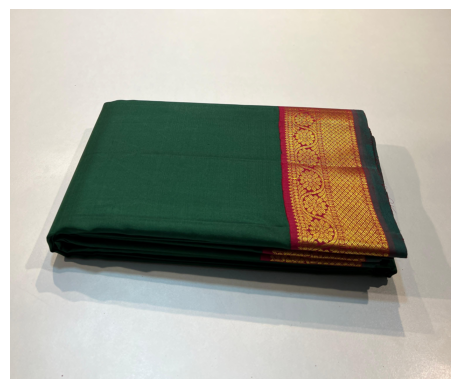

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

# Example usage:
display_image("/content/WhatsApp Image 2024-04-11 at 12.51.06 PM (1).jpeg")


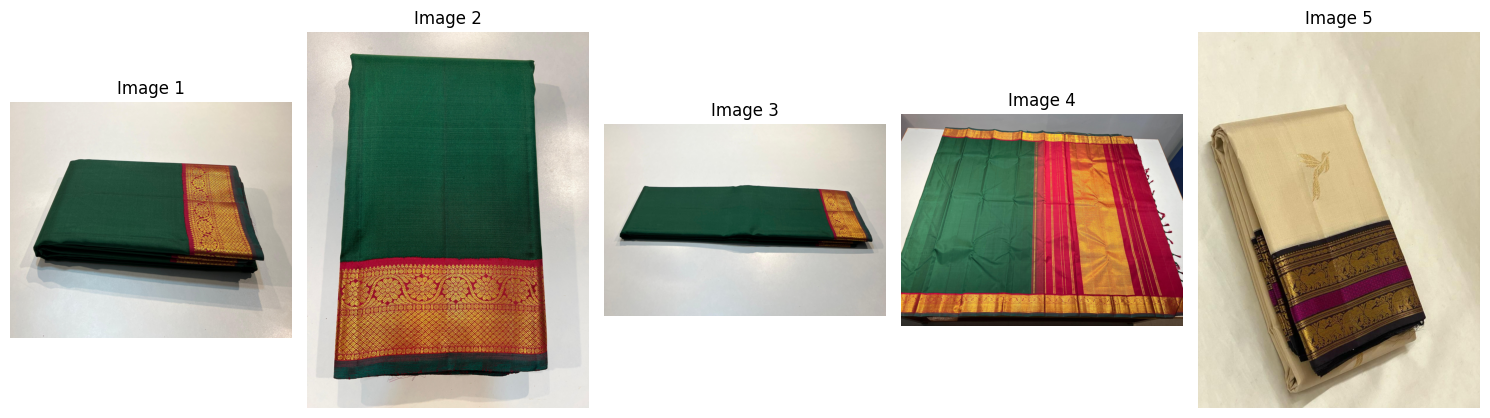

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(image_paths):
    if len(image_paths) != 5:
        print("Error: You need exactly 3 image paths to display.")
        return

    # Create a new figure and axis for each image
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    # Iterate over image paths and display each image
    for i, image_path in enumerate(image_paths):
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f"Image {i+1}")

    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()

# Example usage:
display_images(mm)
